In [2]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200

In [3]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB

In [4]:
acc_healthy = pd.read_csv('data_new_preprocessed/acc_healthy_samples.csv')
acc_15 = pd.read_csv('data_new_preprocessed/acc_15_samples.csv')
acc_35 = pd.read_csv('data_new_preprocessed/acc_35_samples.csv')

gyro_healthy = pd.read_csv('data_new_preprocessed/gyro_healthy_samples.csv')
gyro_15 = pd.read_csv('data_new_preprocessed/gyro_15_samples.csv')
gyro_35 = pd.read_csv('data_new_preprocessed/gyro_35_samples.csv')

gyro_agg_healthy = pd.read_csv('data_new_preprocessed/gyro_agg_healthy_samples.csv')
gyro_agg_15 = pd.read_csv('data_new_preprocessed/gyro_agg_15_samples.csv')
gyro_agg_35 = pd.read_csv('data_new_preprocessed/gyro_agg_35_samples.csv')

In [5]:
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_15_data = np.array([acc_15[col].values for col in acc_15.columns if col.startswith('Sample')])
acc_35_data = np.array([acc_35[col].values for col in acc_35.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_15_data,acc_35_data]

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_15_data = np.array([gyro_15[col].values for col in gyro_15.columns if col.startswith('Sample')])
gyro_35_data = np.array([gyro_35[col].values for col in gyro_35.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_15_data,gyro_35_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_15_data = np.array([gyro_agg_15[col].values for col in gyro_agg_15.columns if col.startswith('Sample')])
gyro_agg_35_data = np.array([gyro_agg_35[col].values for col in gyro_agg_35.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data, gyro_agg_15_data, gyro_agg_35_data]

In [69]:
def prepare_data(data_array,spl_order = 3, num_knots = 30, frequencies = None, 
                 mode = 'binary', training_samples = [10,10],lambda0=None, training_set = None):
    N = len(data_array[0][0])
    spl_order = spl_order
    num_knots = num_knots
    if frequencies is None:
        times = np.linspace(0,N*10,N)
        knot_list = np.quantile(times,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, times, spl_order, num_knots)

    else:
        knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, frequencies, spl_order, num_knots)

    K = num_knots+2
    if mode == 'binary':
        M = 2
        if training_set:
            IL1 = training_set[0]
            IL2 = training_set[1]
            IL = IL1+IL2

            num_healthy = len(data_array[0])
            num_damaged = len(data_array[1])+len(data_array[2])
            data_array_damaged = np.concatenate([data_array[1], data_array[2]])
            total = num_healthy + num_damaged
            IT = total - IL

            sampling_order_1 = np.random.permutation([*range(num_healthy)])
            sampling_order_2 = np.random.permutation([*range(num_damaged)])

            y_labeled = np.concatenate(
            [np.array(data_array[0])[-training_set[0]:],
                np.array(data_array_damaged)[-training_set[1]:]])
            y_labeled = y_labeled.T
            labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


            y_test = np.concatenate(
                [np.array(data_array[0])[:-training_set[0]],
                    np.array(data_array_damaged)[:-training_set[1]]
                    ]
            )
            y_test = y_test.T
            y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
            if lambda0 is None:
                lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

            IT = y_test.shape[1]

        else:
            IL1 = training_samples[0]
            IL2 = training_samples[1]
            IL = IL1+IL2

            num_healthy = len(data_array[0])
            num_damaged = len(data_array[1])+len(data_array[2])
            data_array_damaged = np.concatenate([data_array[1], data_array[2]])
            total = num_healthy + num_damaged
            IT = total - IL

            sampling_order_1 = np.random.permutation([*range(num_healthy)])
            sampling_order_2 = np.random.permutation([*range(num_damaged)])

            y_labeled = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[:IL1]],
                np.array(data_array_damaged)[sampling_order_2[:IL2]]])
            y_labeled = y_labeled.T
            labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


            y_test = np.concatenate(
                [np.array(data_array[0])[sampling_order_1[IL1:]],
                    np.array(data_array_damaged)[sampling_order_2[IL2:]]
                    ]
            )
            y_test = y_test.T
            y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
            if lambda0 is None:
                lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

            IT = y_test.shape[1]

    if mode == 'all':
        M = 3
        if training_set:
            IL1 = training_set[0]
            IL2 = training_set[1]
            IL3 = training_set[2]
            IL = IL1+IL2+IL3

            num_healthy = len(data_array[0])
            num_damaged = len(data_array[1])
            num_very_damaged = len(data_array[2])

            total = num_healthy + num_damaged + num_very_damaged
            IT = total - IL

            sampling_order_1 = np.random.permutation([*range(num_healthy)])
            sampling_order_2 = np.random.permutation([*range(num_damaged)])
            sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

            y_labeled = np.concatenate(
            [np.array(data_array[0])[-training_set[0]:],
                np.array(data_array[1])[-training_set[1]:],
                np.array(data_array[2])[-training_set[2]:],
                ])
            y_labeled = y_labeled.T
            labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


            y_test = np.concatenate(
                [np.array(data_array[0])[:-training_set[0]],
                    np.array(data_array[1])[:-training_set[1]],
                    np.array(data_array[2])[:-training_set[2]]
                    ]
            )
            y_test = y_test.T
            y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
            if lambda0 is None:
                lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

            IT = y_test.shape[1]
        else:
            IL1 = training_samples[0]
            IL2 = training_samples[1]
            IL3 = training_samples[2]
            IL = IL1+IL2+IL3

            num_healthy = len(data_array[0])
            num_damaged = len(data_array[1])
            num_very_damaged = len(data_array[2])

            total = num_healthy + num_damaged + num_very_damaged
            IT = total - IL

            sampling_order_1 = np.random.permutation([*range(num_healthy)])
            sampling_order_2 = np.random.permutation([*range(num_damaged)])
            sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

            y_labeled = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[:IL1]],
                np.array(data_array[1])[sampling_order_2[:IL2]],
                np.array(data_array[2])[sampling_order_3[:IL3]],
                ])
            y_labeled = y_labeled.T
            labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


            y_test = np.concatenate(
                [np.array(data_array[0])[sampling_order_1[IL1:]],
                    np.array(data_array[1])[sampling_order_2[IL2:]],
                    np.array(data_array[2])[sampling_order_3[IL3:]]
                    ]
            )
            y_test = y_test.T
            y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
            if lambda0 is None:
                lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

            IT = y_test.shape[1]

    data_out = {
    "N": N,
    "IL": IL,
    "K": K,
    "M": M,
    "x": B0,
    "labels": labels,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "y_test": y_test,
    }

    return data_out, y_test_labels, IT, IL, total, B0, knot_list,N
    

def get_results(model, data, labels, IT, IL, total, mode = 'binary',plot = False, seed = None, N=None):
    if not seed:
        seed = np.random.randint(0,100000)
        print(seed)
    if mode == 'binary':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b)/(total-IL)
        print('hit rate = ',hit_rate)
    if mode == 'all':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2
        indices_cat3 = labels == 3

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))
        c = sum((cat3["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b+c)/(total-IL)
        print('hit rate = ',hit_rate)

    if plot and mode == 'binary':
        fig, ax = plt.subplots(2,1,figsize=(16,12),tight_layout=True)

        x = np.arange(1,len(cat1p)+1)
        ax[0].scatter(x, (cat1p["mean"].values))
        ax[0].errorbar(x, cat1p["mean"].values, np.abs([cat1p["mean"].values-cat1p["hdi_3%"].values,
                    cat1p["hdi_97%"].values-cat1p["mean"].values]), linestyle='none')


        x = np.arange(1,len(cat2p)+1)
        ax[1].scatter(x, (cat2p["mean"].values))
        ax[1].errorbar(x, cat2p["mean"].values, np.abs([cat2p["mean"].values-cat2p["hdi_3%"].values,
                    cat2p["hdi_97%"].values-cat2p["mean"].values]), linestyle='none')



        ax[0].set_title('Healthy', loc='left',fontsize = 20)
        ax[0].set_ylabel('Probability')
        ax[1].set_title('Damaged', loc='left',fontsize = 20)
        ax[1].set_ylabel('Probability')
        ax[0].set_xticks([1,len(cat1p)])
        ax[1].set_xticks([1,len(cat2p)])
        ax[0].set_ylim([-0.05,1.05])
        ax[0].set_yticks([0,1])
        ax[1].set_ylim([-0.05,1.05])
        ax[1].set_yticks([0,1])


        # x = np.linspace(0,150,N)
        # fig = plt.figure(figsize=(12, 8), tight_layout = True)
        # axes = plt.subplot(1, 1 ,1)
        # y_pred= result.stan_variable('y_pred')[:,:]
        # axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
        # axes.set_xlabel('Time [ms]',fontsize = 15)
        # axes.set_ylabel('Amplitude',fontsize = 15)
        # axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
        # axes.plot(x,acc_healthy_data[0], color = 'k',alpha=0.8)
    # if plot and mode == 'all':
    
    return hit_rate, result#,[indices_cat1,indices_cat2,indices_cat3]
        

14:56:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:56:11 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.972972972972973


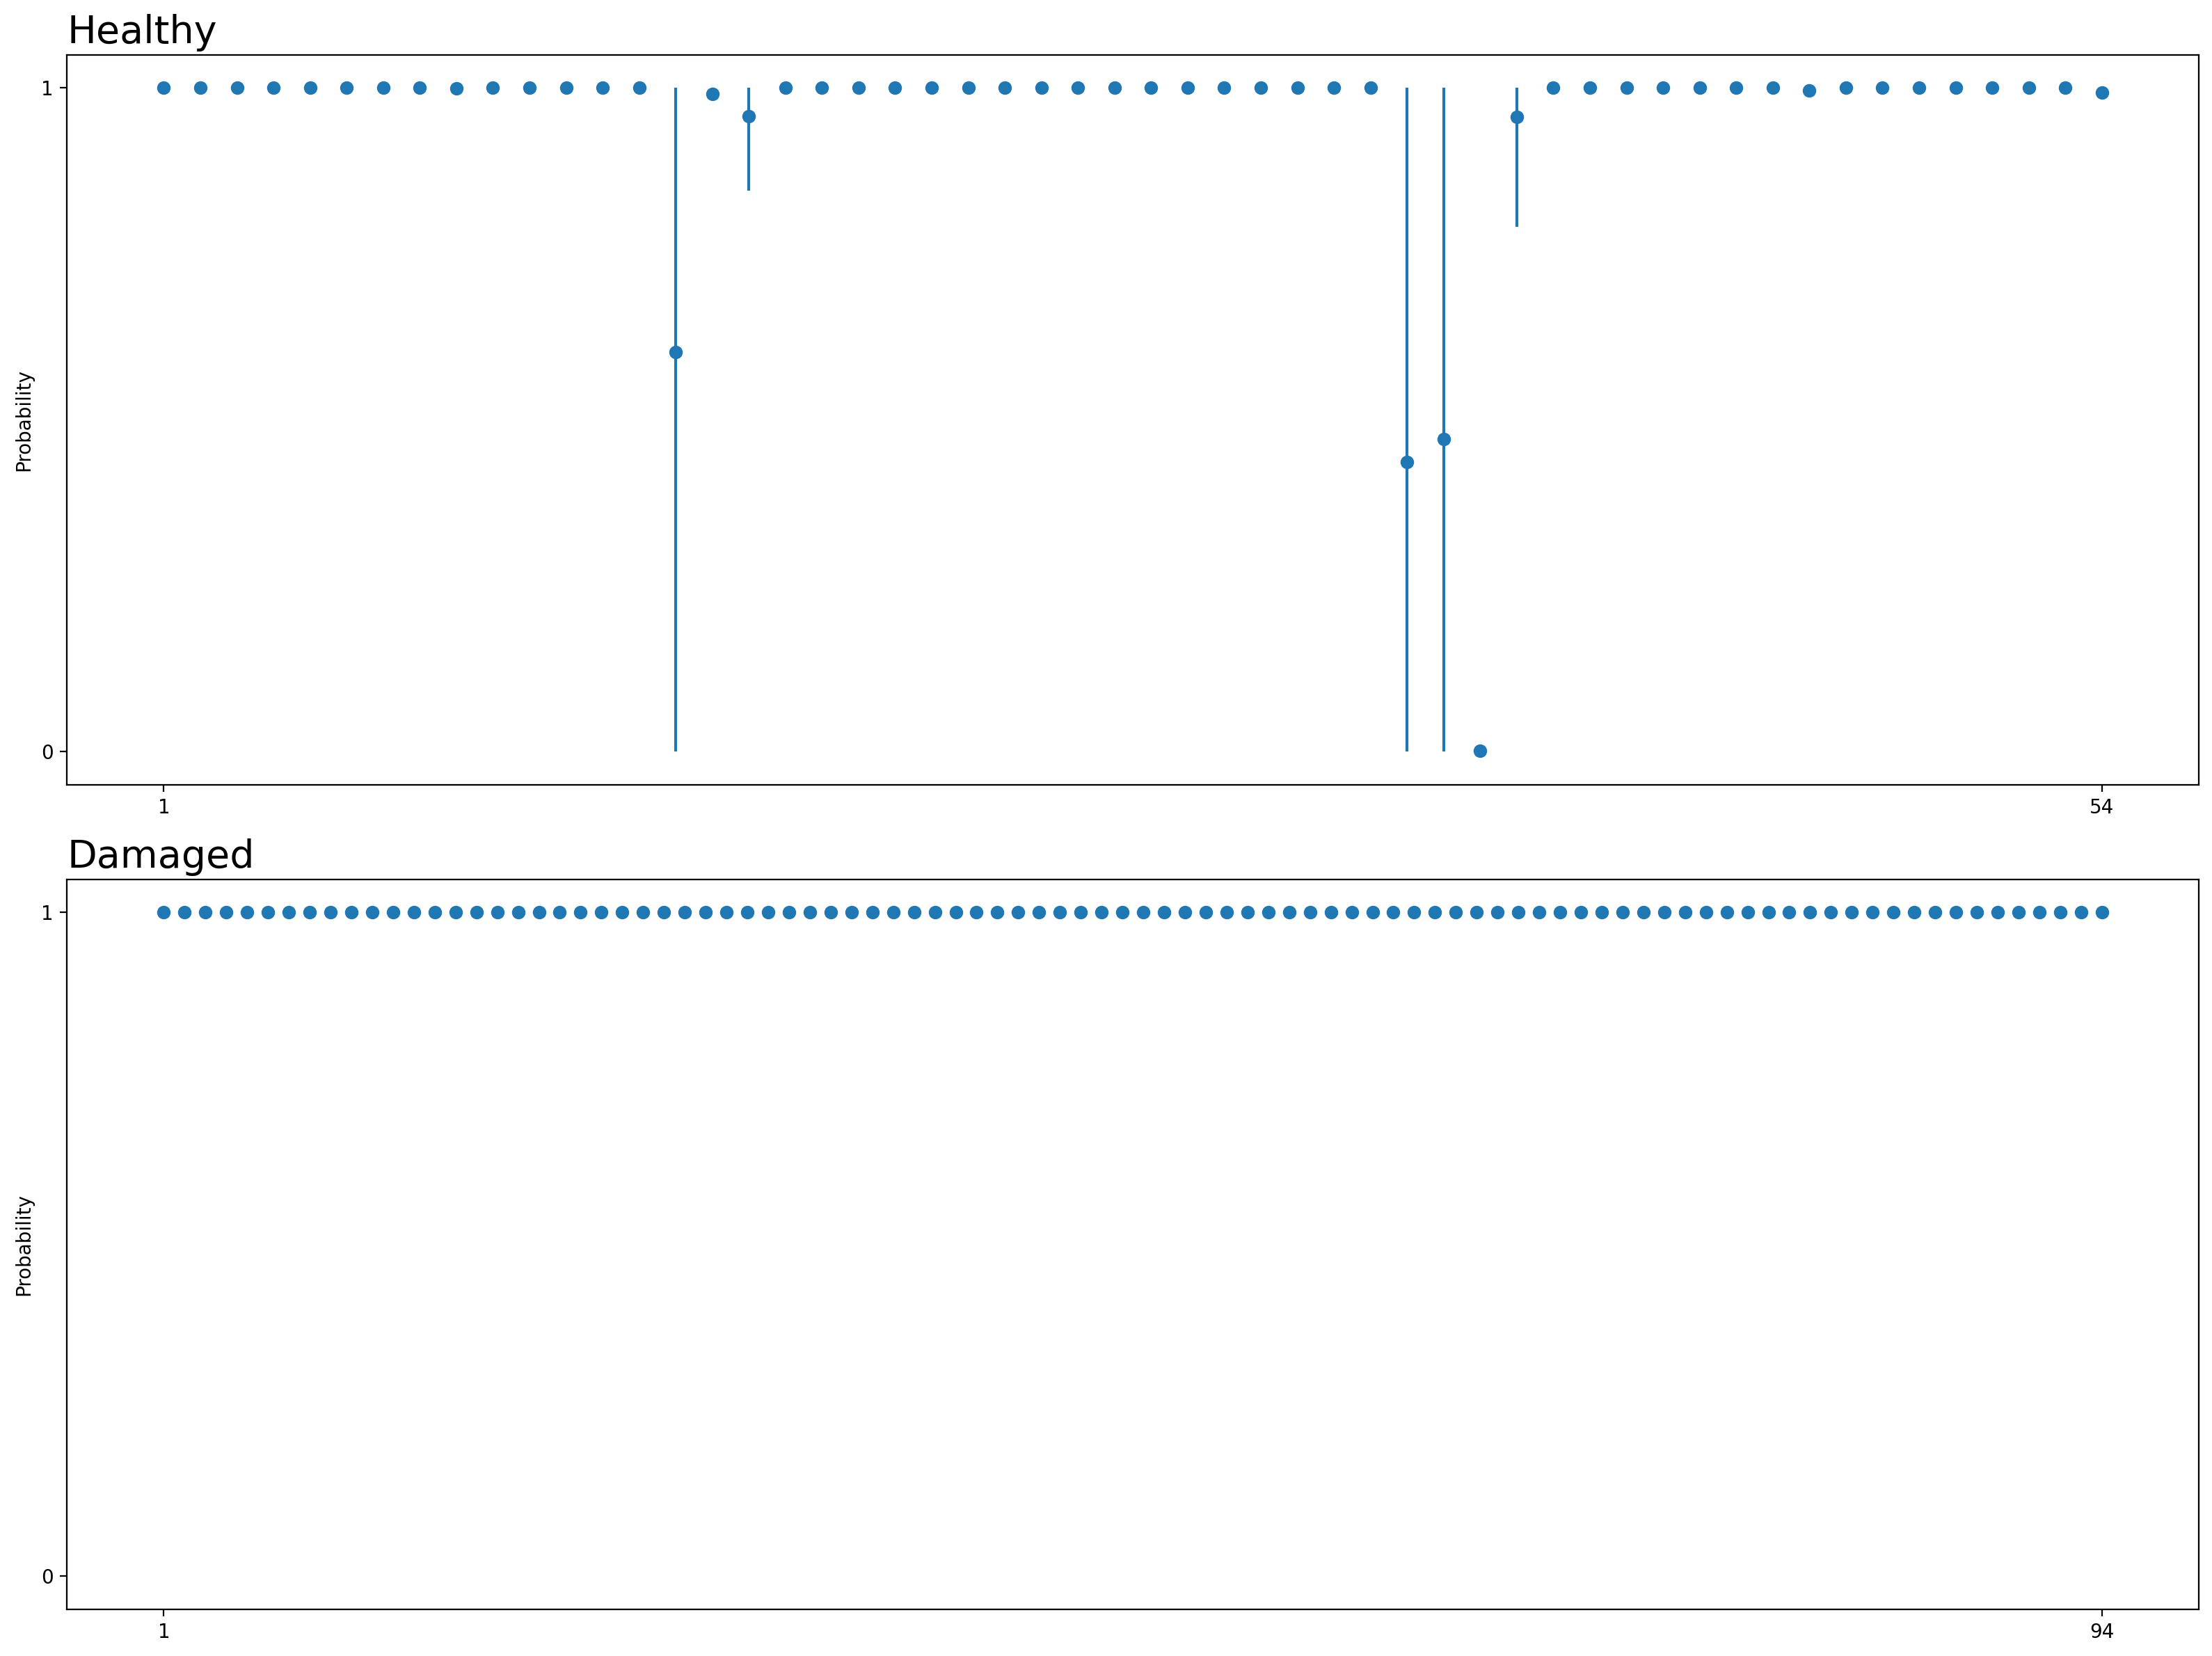

In [41]:
num_knots = 13
data, labels, IT, IL, total,B0,knot_list,N = prepare_data(acc,frequencies=None,training_samples=[5,5], 
                                                        num_knots=num_knots, mode = 'binary',training_set=[5,5])
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
samples = get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='binary',plot=True,N=N)

12:48:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:48:27 - cmdstanpy - INFO - CmdStan done processing.


12:48:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:48:29 - cmdstanpy - INFO - CmdStan done processing.


12:48:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:48:31 - cmdstanpy - INFO - CmdStan done processing.


(7.5, 14.0)

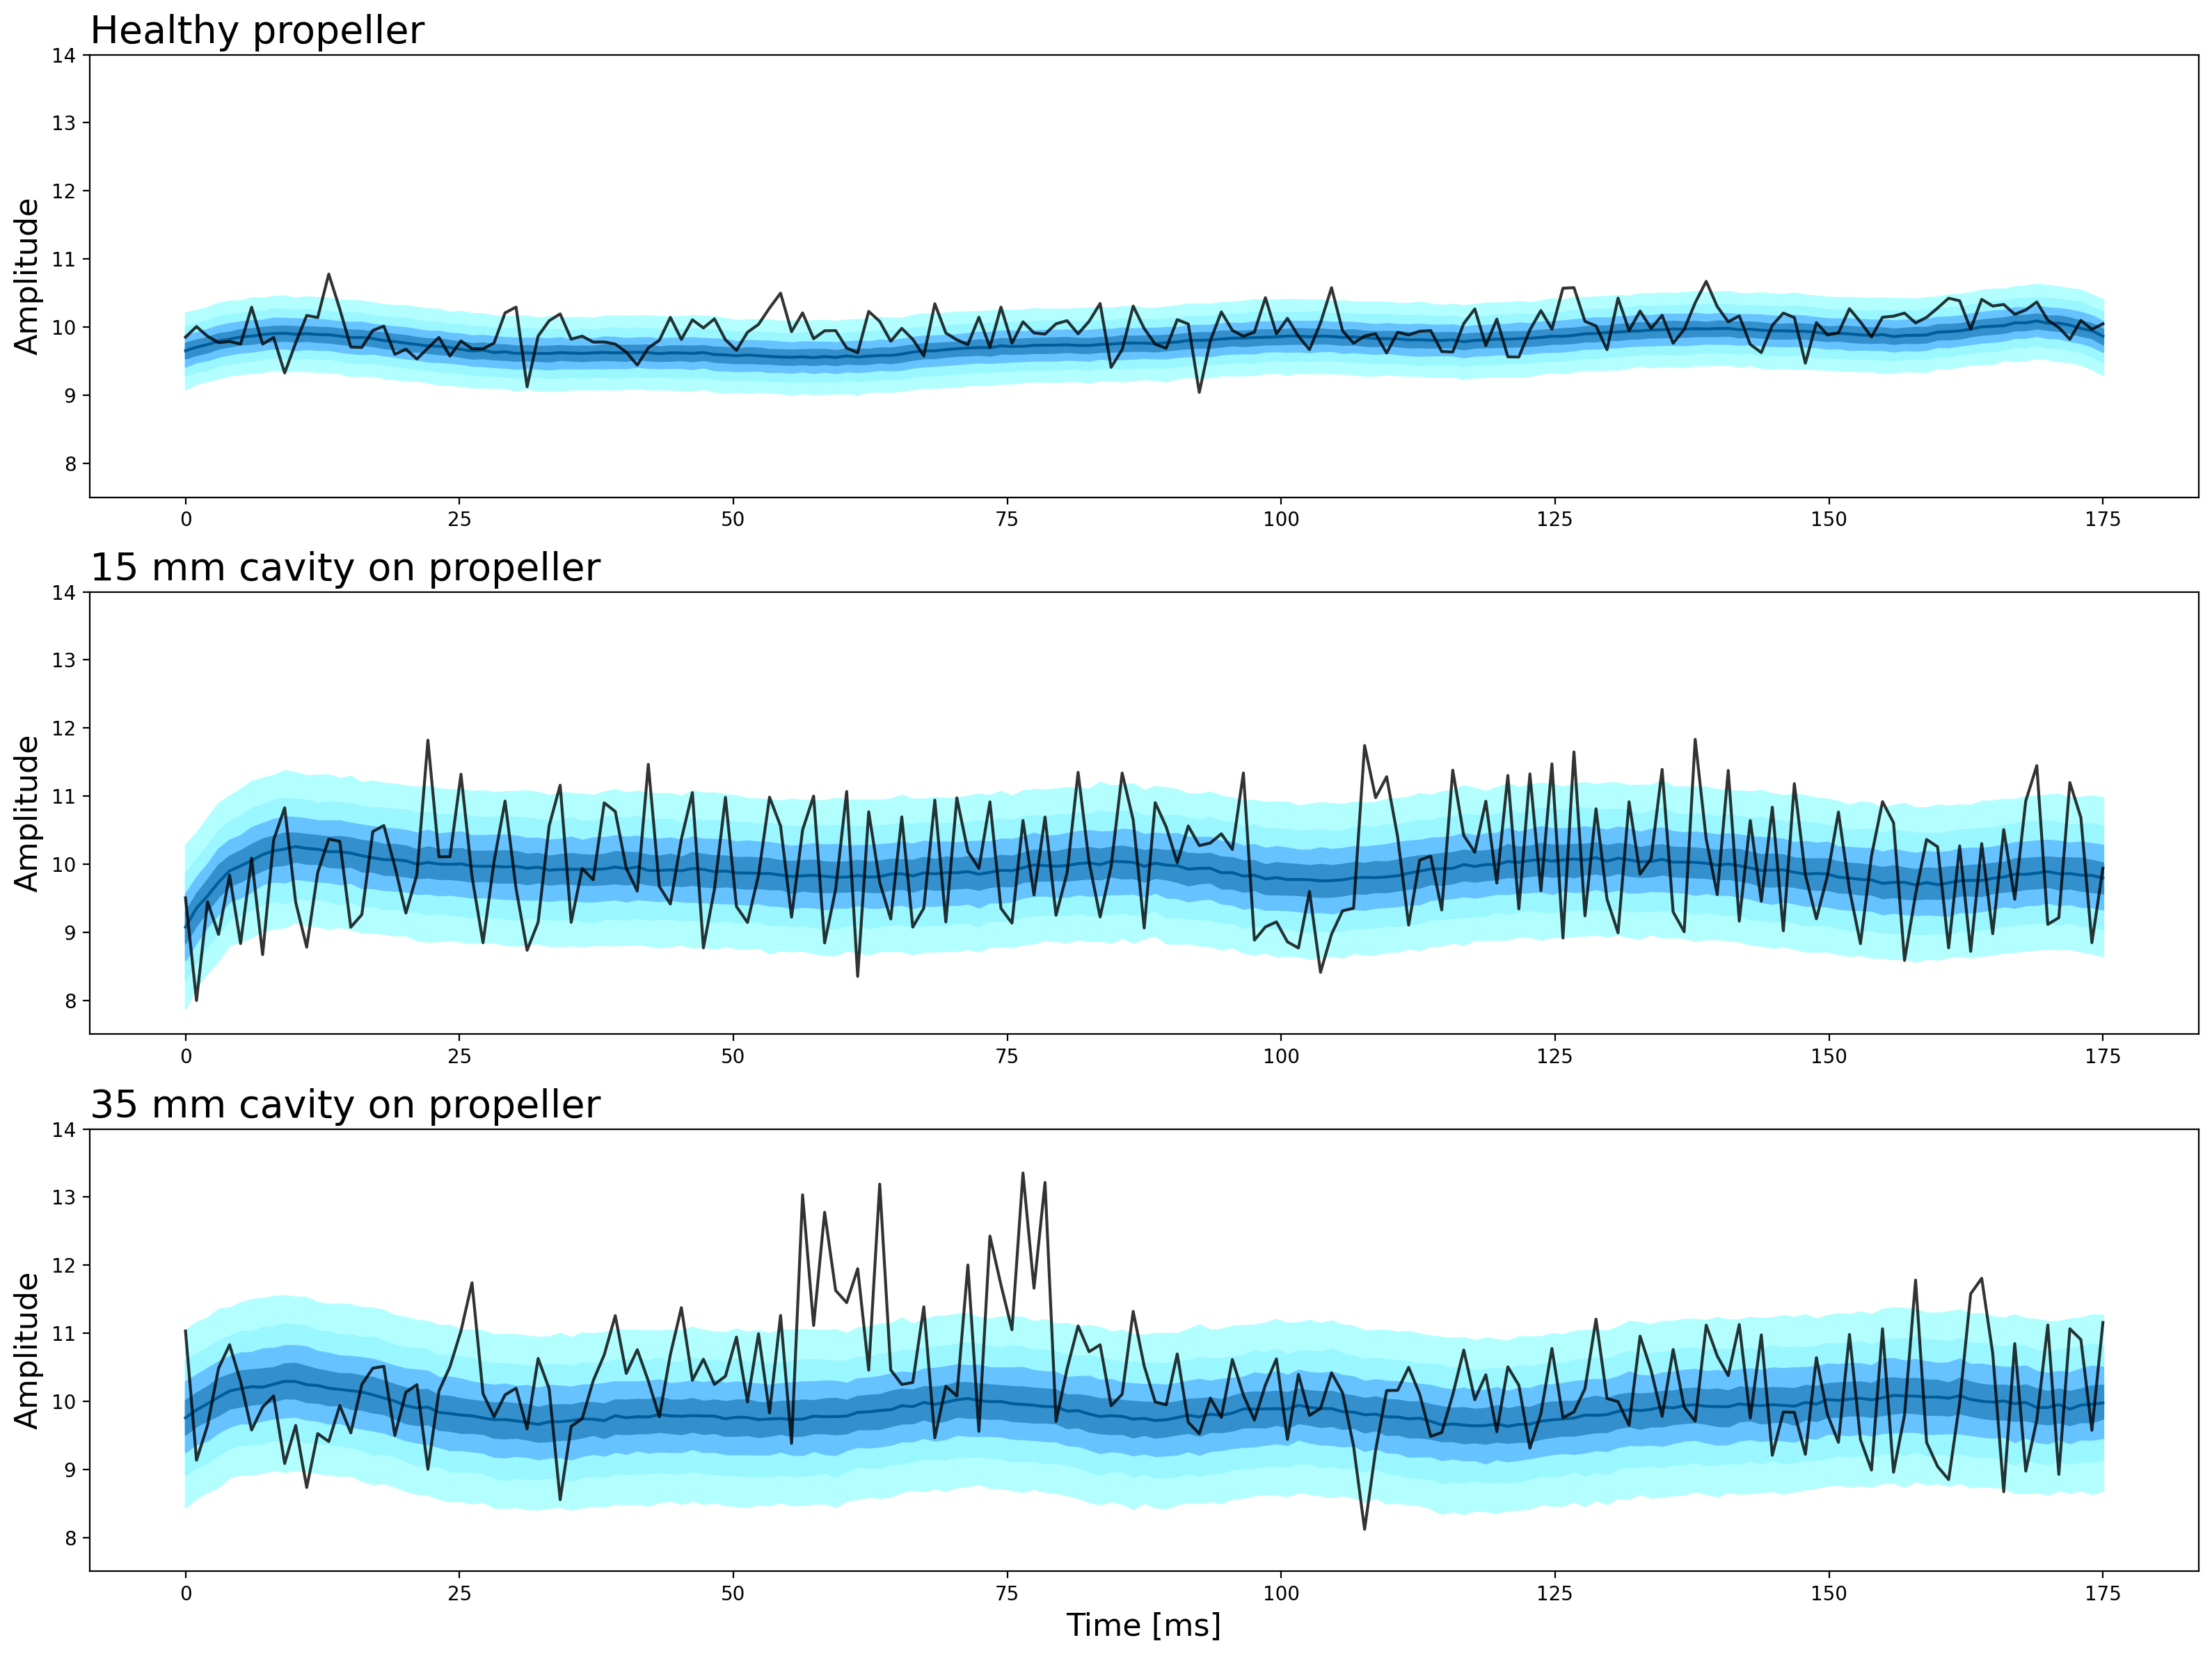

In [8]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior1 = model_posterior.sample(data=data_ppc)
fig,axes = plt.subplots(3,1,figsize=[16,12],tight_layout=True)

x = np.linspace(0,175,175)
y_pred1= samples_posterior1.stan_variable('y_hat')[:,:]
axes[0] = ribbon_plot(x,y_pred1,axes[0],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[0].set_ylabel('Amplitude',fontsize = 16)
axes[0].set_title('Healthy propeller', loc= 'left',fontsize = 20)
axes[0].plot(x,acc_healthy_data[32], color = 'k',alpha=0.8)

model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[1]))])
y = acc[1][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior2 = model_posterior.sample(data=data_ppc)

y_pred2= samples_posterior2.stan_variable('y_hat')[:,:]
axes[1] = ribbon_plot(x,y_pred2,axes[1],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[1].set_ylabel('Amplitude',fontsize = 16)
axes[1].set_title('15 mm cavity on propeller', loc= 'left',fontsize = 20)
axes[1].plot(x,acc_15_data[10], color = 'k',alpha=0.8)



model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 8
num_knots = 13
N = 175
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[2]))])
y = acc[2][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior3 = model_posterior.sample(data=data_ppc)

y_pred3= samples_posterior3.stan_variable('y_hat')[:,:]
axes[2] = ribbon_plot(x,y_pred3,axes[2],supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes[2].set_ylabel('Amplitude',fontsize = 16)
axes[2].set_title('35 mm cavity on propeller', loc= 'left',fontsize = 20)
axes[2].plot(x,acc_35_data[10], color = 'k',alpha=0.8)
axes[2].set_xlabel('Time [ms]',fontsize = 16)


axes[0].set_ylim(7.5,14)
axes[1].set_ylim(7.5,14)
axes[2].set_ylim(7.5,14)

In [50]:
num_knots = 13
data, labels, IT, IL, total,B0,knot_list,n = prepare_data(acc,frequencies=None,training_samples=[5,5,5],training_set=[5,5,5], 
                                                        num_knots=num_knots, mode = 'all')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
res,indicies = get_results(model=model,data=data,labels=labels,IT=IT,IL=IL,total=total,mode='all',plot=True)

15:11:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:11:11 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.4475524475524476


In [59]:
probs = indicies.stan_variable('probabilities')
az.summary(indicies, var_names=[
    'probabilities'])[200:260]

/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"probabilities[1,57]",0.516,0.374,0.007,1.000,0.005,0.004,5699.0,3380.0,1.0
"probabilities[1,58]",0.704,0.326,0.067,1.000,0.005,0.004,5073.0,3174.0,1.0
"probabilities[1,59]",0.561,0.377,0.011,1.000,0.005,0.004,4702.0,3658.0,1.0
"probabilities[1,60]",0.507,0.418,0.001,1.000,0.006,0.004,5032.0,3837.0,1.0
"probabilities[1,61]",0.127,0.246,0.000,0.743,0.004,0.003,4617.0,3579.0,1.0
"probabilities[1,62]",0.298,0.369,0.000,0.986,0.005,0.004,5064.0,3420.0,1.0
"probabilities[1,63]",0.168,0.308,0.000,0.940,0.005,0.004,4445.0,4114.0,1.0
"probabilities[1,64]",0.741,0.365,0.010,1.000,0.006,0.004,5040.0,3367.0,1.0
"probabilities[1,65]",0.798,0.342,0.011,1.000,0.006,0.004,4424.0,3180.0,1.0
"probabilities[1,66]",0.857,0.284,0.101,1.000,0.005,0.003,4677.0,3525.0,1.0


In [ ]:
az.summary(res, var_names=[
    'probabilities'])

/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/kacperjarzyna/opt/anaconda3/envs/venv_stan/lib/python3.10/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_sampl

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"probabilities[0,0]",0.000,0.000,0.000,0.000,0.000,0.000,5922.0,3869.0,1.0
"probabilities[0,1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,2]",0.829,0.338,0.004,1.000,0.005,0.004,4659.0,3058.0,1.0
"probabilities[0,3]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"probabilities[0,4]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
"probabilities[2,138]",0.000,0.011,0.000,0.000,0.000,0.000,4491.0,3519.0,1.0
"probabilities[2,139]",0.000,0.016,0.000,0.000,0.000,0.000,5033.0,3910.0,1.0
"probabilities[2,140]",0.106,0.228,0.000,0.651,0.004,0.003,4373.0,3515.0,1.0
"probabilities[2,141]",0.047,0.168,0.000,0.229,0.003,0.002,4882.0,3959.0,1.0


In [53]:
x = [probs[:,0,142],probs[:,0,138],probs[:,0,0],probs[:,0,4]]
y = [probs[:,1,142],probs[:,1,138],probs[:,1,0],probs[:,1,4]]
z = [probs[:,2,142],probs[:,2,138],probs[:,2,0],probs[:,2,4]]

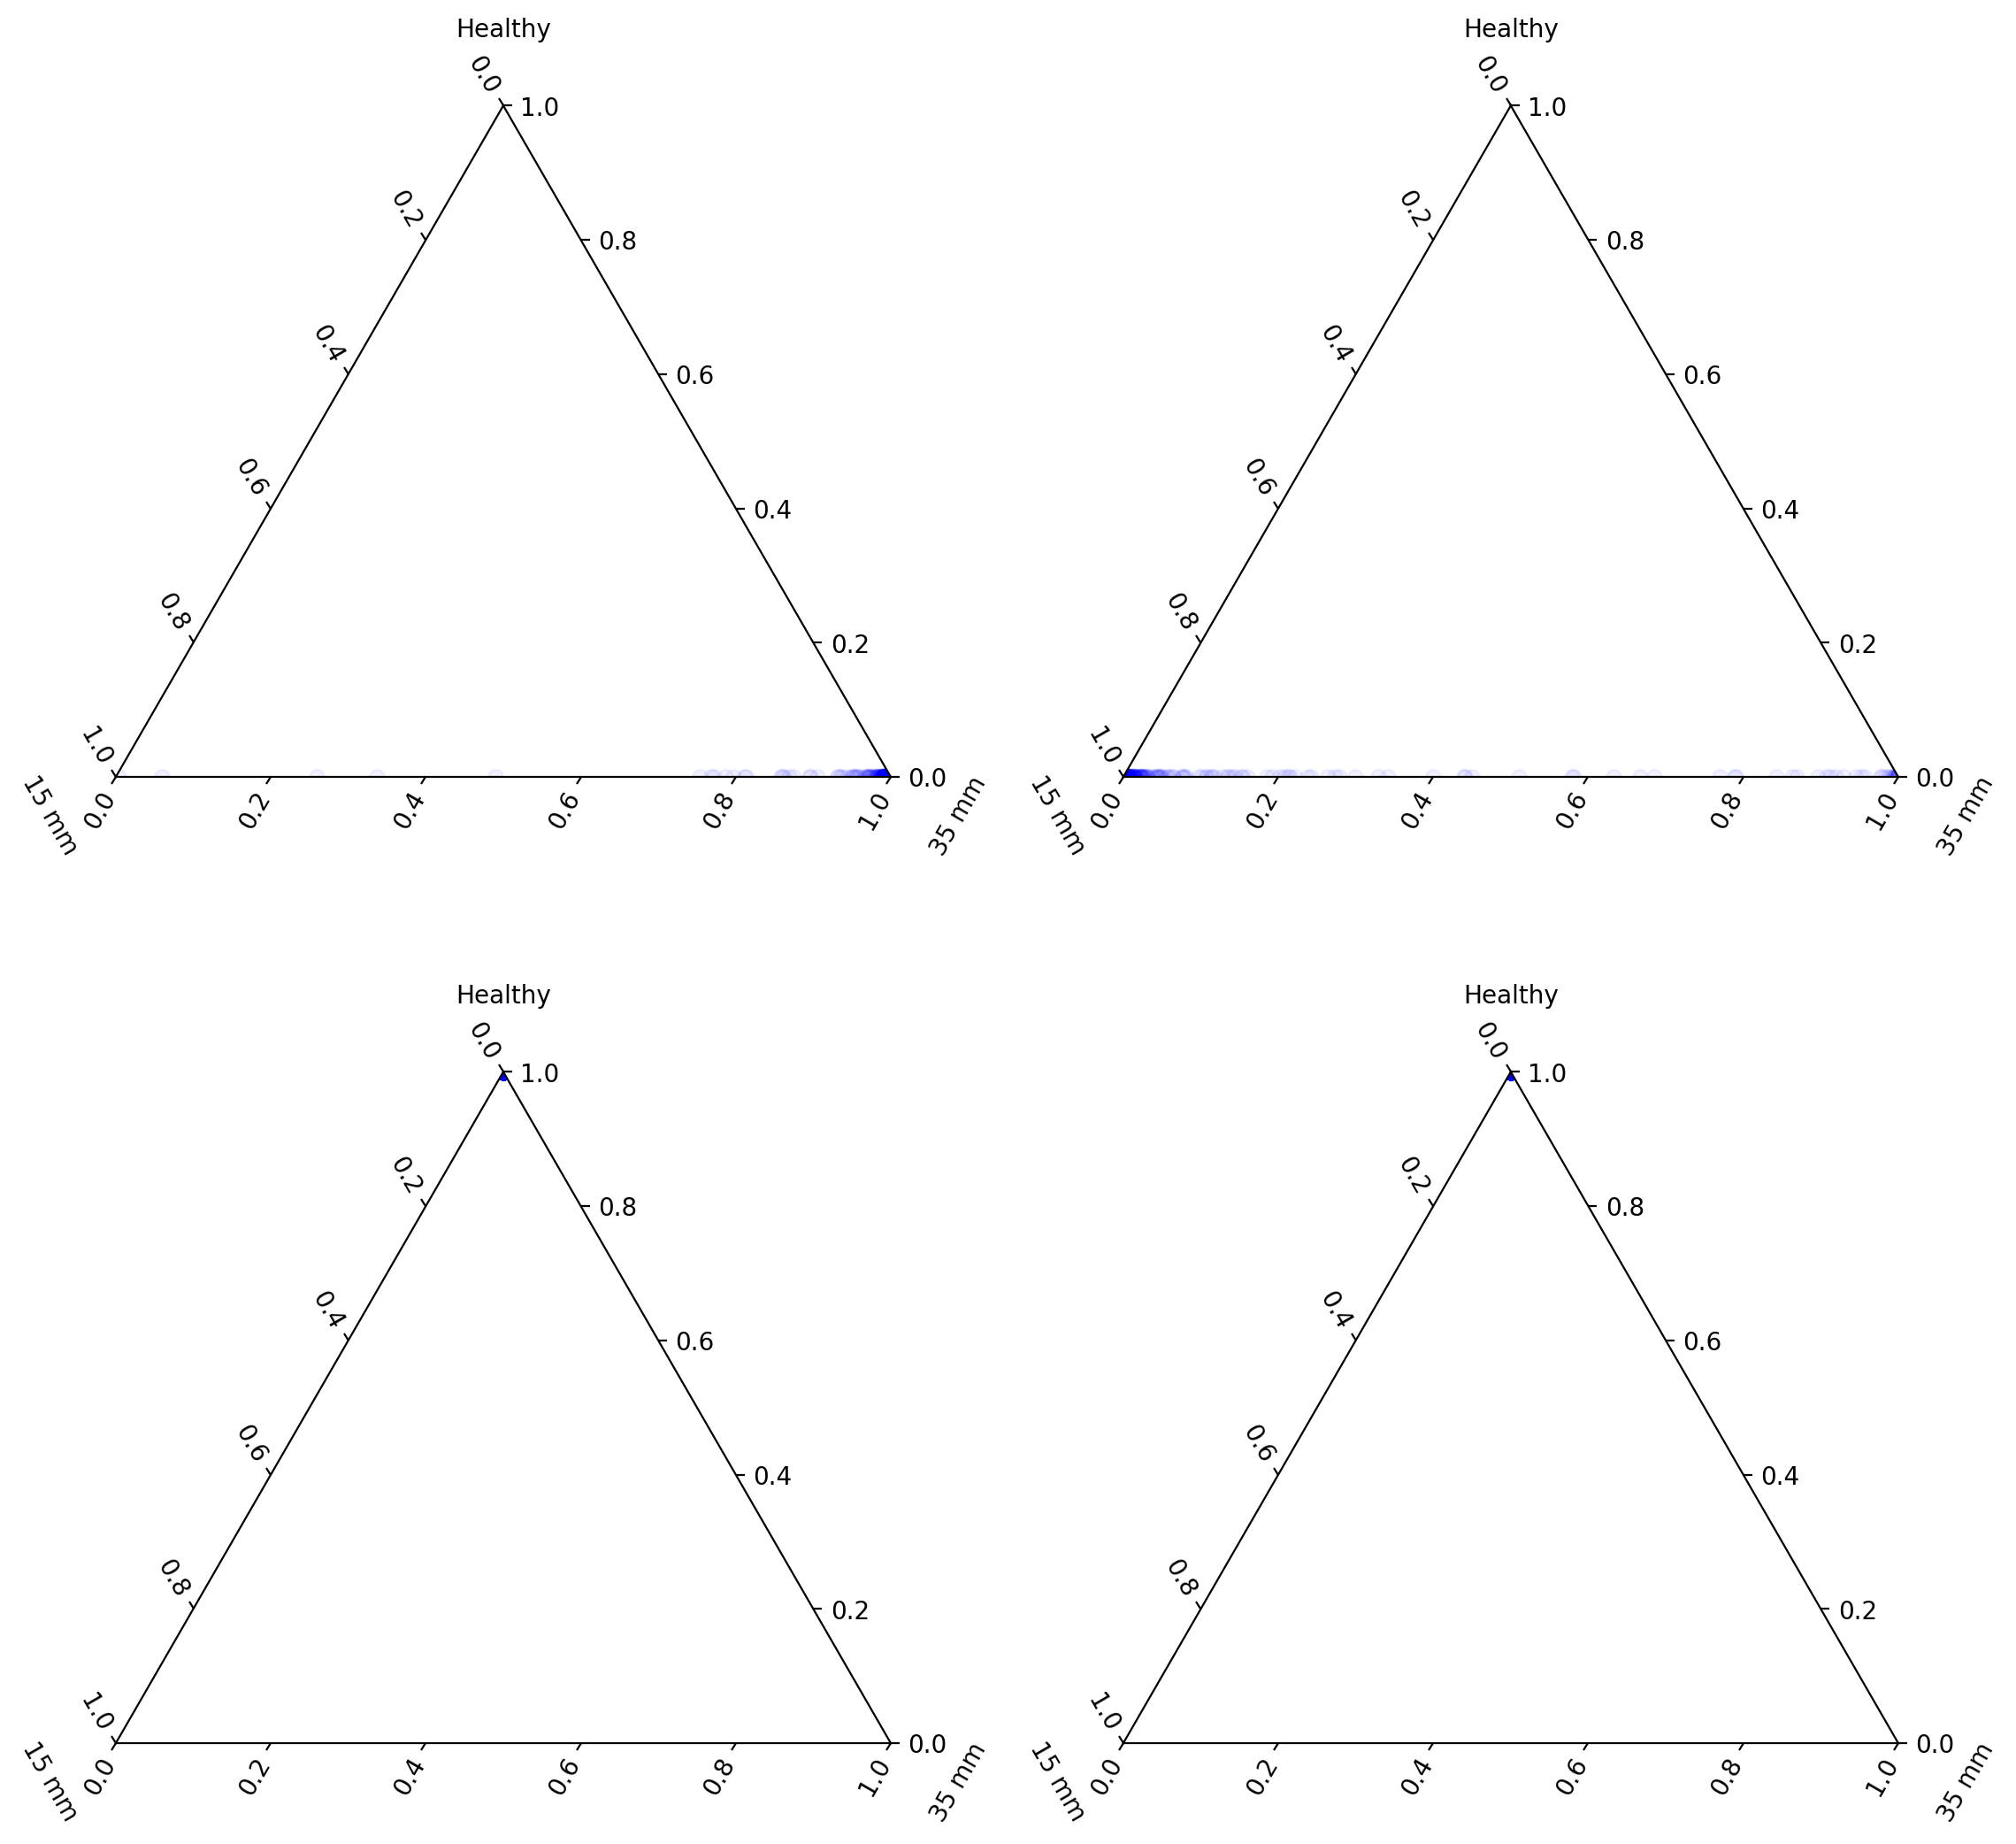

In [55]:
import mpltern 

fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(wspace=0.3)

positions = ['tick1', 'tick2','tick3', 'tick4']
for i, position in enumerate(positions):
    ax = fig.add_subplot(2, 2, i + 1, projection='ternary')

    ax.set_tlabel('Healthy')
    ax.set_llabel('15 mm')
    ax.set_rlabel('35 mm')
    ax.scatter(x[i], y[i], z[i], c = 'blue',alpha = 0.05)
    ax.set_title(f"", pad=42)

plt.show()

### Diffrences between models
Three binary models for detecting drone propeller damage have been developed. The models differ primarily in terms of input data, which can be distinguished as follows:

    accelerometer with data aggregation in the time domain,
    gyroscope without data aggregation in the frequency domain,
    gyroscope with data aggregation in the frequency domain.

These models were developed due to the possibility of their direct application in unmanned aerial vehicles. The model using an accelerometer will require less computational power during integration, due to the limited number of operations performed. Meanwhile, the model based on a gyroscope must process input data after a Fourier transform, which increases computational complexity.

In [71]:
knots = [15]
frequencies = gyro_agg_healthy['Frequencies']
num_iters = 100
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list,N = prepare_data(acc, frequencies=None, training_samples=[7,7],training_set=None, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary')[0])
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('res_new/2_agg_results.csv')

model = CmdStanModel(stan_file='stan/mix.stan')

# # gyroscope with data aggregation in the frequency domain
# result_dict_gyro_agg = {}
# for num_knots in knots:
#     res = []
#     for i in range(num_iters):
#         data, labels, IT, IL, total, B0, knot_list,N = prepare_data(gyro_agg, frequencies=frequencies, training_samples=[7,7], training_set=[7,7], num_knots=num_knots, mode = 'binary')
#         res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary')[0])
#     result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
#     pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
#     pd_res.to_csv('res_new/2_gyro_agg_results.csv')

20:36:08 - cmdstanpy - INFO - CmdStan start processing


37866


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:16 - cmdstanpy - INFO - CmdStan done processing.


20:36:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
98768


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:23 - cmdstanpy - INFO - CmdStan done processing.


20:36:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
49167


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:31 - cmdstanpy - INFO - CmdStan done processing.


20:36:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
84829


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:38 - cmdstanpy - INFO - CmdStan done processing.


20:36:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
28472


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:46 - cmdstanpy - INFO - CmdStan done processing.


20:36:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
74885


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:36:53 - cmdstanpy - INFO - CmdStan done processing.


20:36:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
81335


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:01 - cmdstanpy - INFO - CmdStan done processing.
20:37:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


20:37:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888
52561


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:08 - cmdstanpy - INFO - CmdStan done processing.


20:37:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
43563


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:16 - cmdstanpy - INFO - CmdStan done processing.


20:37:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
79410


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:23 - cmdstanpy - INFO - CmdStan done processing.


20:37:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
87830


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:31 - cmdstanpy - INFO - CmdStan done processing.


20:37:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
20:37:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888
22120


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:38 - cmdstanpy - INFO - CmdStan done processing.


20:37:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
22244


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:46 - cmdstanpy - INFO - CmdStan done processing.


20:37:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
73080


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:37:53 - cmdstanpy - INFO - CmdStan done processing.


20:37:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9375
30759


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:00 - cmdstanpy - INFO - CmdStan done processing.


20:38:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
15617


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:08 - cmdstanpy - INFO - CmdStan done processing.


20:38:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
91021


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:16 - cmdstanpy - INFO - CmdStan done processing.


20:38:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
8739


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:23 - cmdstanpy - INFO - CmdStan done processing.


20:38:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
63982


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:30 - cmdstanpy - INFO - CmdStan done processing.
20:38:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


20:38:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
64690


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:38 - cmdstanpy - INFO - CmdStan done processing.


20:38:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9375
5969


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:45 - cmdstanpy - INFO - CmdStan done processing.


20:38:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
88614


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:38:53 - cmdstanpy - INFO - CmdStan done processing.


20:38:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
22230


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:00 - cmdstanpy - INFO - CmdStan done processing.


20:39:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
40786


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:07 - cmdstanpy - INFO - CmdStan done processing.


20:39:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778
87076


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:15 - cmdstanpy - INFO - CmdStan done processing.


20:39:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
78969


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:22 - cmdstanpy - INFO - CmdStan done processing.


20:39:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
67740


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:30 - cmdstanpy - INFO - CmdStan done processing.


20:39:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
94677


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:37 - cmdstanpy - INFO - CmdStan done processing.


20:39:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
99


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:45 - cmdstanpy - INFO - CmdStan done processing.


20:39:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
34363


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:39:52 - cmdstanpy - INFO - CmdStan done processing.


20:39:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
17976


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:00 - cmdstanpy - INFO - CmdStan done processing.


20:40:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
96000


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:08 - cmdstanpy - INFO - CmdStan done processing.


20:40:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778
33352


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:15 - cmdstanpy - INFO - CmdStan done processing.


20:40:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
46614


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:23 - cmdstanpy - INFO - CmdStan done processing.


20:40:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888
93063


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:30 - cmdstanpy - INFO - CmdStan done processing.


20:40:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
3687


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:38 - cmdstanpy - INFO - CmdStan done processing.


20:40:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
7578


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:45 - cmdstanpy - INFO - CmdStan done processing.


20:40:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
77093


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:40:53 - cmdstanpy - INFO - CmdStan done processing.


20:40:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
30433


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:00 - cmdstanpy - INFO - CmdStan done processing.


20:41:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778
69331


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:08 - cmdstanpy - INFO - CmdStan done processing.


20:41:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
5525


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:15 - cmdstanpy - INFO - CmdStan done processing.


20:41:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
35374


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:23 - cmdstanpy - INFO - CmdStan done processing.


20:41:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
90730


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:30 - cmdstanpy - INFO - CmdStan done processing.


20:41:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9444444444444444
99671


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:37 - cmdstanpy - INFO - CmdStan done processing.


20:41:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
66869


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:45 - cmdstanpy - INFO - CmdStan done processing.


20:41:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
8924


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:41:52 - cmdstanpy - INFO - CmdStan done processing.


20:41:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
82412


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:00 - cmdstanpy - INFO - CmdStan done processing.


20:42:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
61847


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:07 - cmdstanpy - INFO - CmdStan done processing.


20:42:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9444444444444444
36721


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:15 - cmdstanpy - INFO - CmdStan done processing.


20:42:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
89681


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:22 - cmdstanpy - INFO - CmdStan done processing.


20:42:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
67873


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:30 - cmdstanpy - INFO - CmdStan done processing.


20:42:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
8691


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:38 - cmdstanpy - INFO - CmdStan done processing.
20:42:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


20:42:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
77299


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:46 - cmdstanpy - INFO - CmdStan done processing.


20:42:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
60361


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:42:54 - cmdstanpy - INFO - CmdStan done processing.


20:42:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
43698


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:02 - cmdstanpy - INFO - CmdStan done processing.
20:43:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


20:43:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
65859


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:10 - cmdstanpy - INFO - CmdStan done processing.


20:43:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
64017


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:18 - cmdstanpy - INFO - CmdStan done processing.


20:43:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
88031


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:26 - cmdstanpy - INFO - CmdStan done processing.


20:43:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
7384


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:34 - cmdstanpy - INFO - CmdStan done processing.


20:43:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
62596


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:42 - cmdstanpy - INFO - CmdStan done processing.


20:43:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
34679


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:51 - cmdstanpy - INFO - CmdStan done processing.


20:43:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888
38905


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:43:58 - cmdstanpy - INFO - CmdStan done processing.


20:43:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
57420


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:07 - cmdstanpy - INFO - CmdStan done processing.


20:44:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
32618


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:15 - cmdstanpy - INFO - CmdStan done processing.
20:44:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


20:44:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
6431


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:23 - cmdstanpy - INFO - CmdStan done processing.


20:44:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
32272


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:31 - cmdstanpy - INFO - CmdStan done processing.


20:44:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
96768


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:39 - cmdstanpy - INFO - CmdStan done processing.


20:44:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888
17060


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:47 - cmdstanpy - INFO - CmdStan done processing.


20:44:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
23018


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:44:55 - cmdstanpy - INFO - CmdStan done processing.


20:44:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9444444444444444
92003


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:04 - cmdstanpy - INFO - CmdStan done processing.


20:45:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
66885


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:12 - cmdstanpy - INFO - CmdStan done processing.


20:45:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
10142


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:20 - cmdstanpy - INFO - CmdStan done processing.


20:45:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
93354


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:28 - cmdstanpy - INFO - CmdStan done processing.


20:45:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9444444444444444
1805


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:36 - cmdstanpy - INFO - CmdStan done processing.


20:45:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
54200


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:44 - cmdstanpy - INFO - CmdStan done processing.


20:45:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
50567


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:45:52 - cmdstanpy - INFO - CmdStan done processing.


20:45:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
59499


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:00 - cmdstanpy - INFO - CmdStan done processing.


20:46:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778
45154


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:08 - cmdstanpy - INFO - CmdStan done processing.


20:46:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
11939


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:17 - cmdstanpy - INFO - CmdStan done processing.


20:46:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
36287


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:26 - cmdstanpy - INFO - CmdStan done processing.


20:46:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
37158


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:35 - cmdstanpy - INFO - CmdStan done processing.


20:46:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
27379


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:44 - cmdstanpy - INFO - CmdStan done processing.


20:46:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9513888888888888
21238


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:46:54 - cmdstanpy - INFO - CmdStan done processing.


20:46:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9583333333333334
53588


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:03 - cmdstanpy - INFO - CmdStan done processing.


20:47:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
53547


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:12 - cmdstanpy - INFO - CmdStan done processing.


20:47:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9652777777777778
74517


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:21 - cmdstanpy - INFO - CmdStan done processing.


20:47:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
50077


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:31 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9722222222222222
85645


20:47:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:41 - cmdstanpy - INFO - CmdStan done processing.


20:47:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
80158


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:47:51 - cmdstanpy - INFO - CmdStan done processing.


20:47:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
50015


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:00 - cmdstanpy - INFO - CmdStan done processing.


20:48:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
60074


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:09 - cmdstanpy - INFO - CmdStan done processing.


20:48:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9722222222222222
23940


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:19 - cmdstanpy - INFO - CmdStan done processing.


20:48:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9930555555555556
22172


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:29 - cmdstanpy - INFO - CmdStan done processing.


20:48:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
63242


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:40 - cmdstanpy - INFO - CmdStan done processing.


20:48:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
31405


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:48:49 - cmdstanpy - INFO - CmdStan done processing.


20:48:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
33228


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:00 - cmdstanpy - INFO - CmdStan done processing.


20:49:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
40000


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:10 - cmdstanpy - INFO - CmdStan done processing.


20:49:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
49998


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:21 - cmdstanpy - INFO - CmdStan done processing.


20:49:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9791666666666666
72538


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:33 - cmdstanpy - INFO - CmdStan done processing.


20:49:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9861111111111112
19547


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:49:43 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9652777777777778


In [72]:
knots = [20]
frequencies = gyro_agg_healthy['Frequencies']
num_iters = 100
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list,N = prepare_data(acc, frequencies=None, training_samples=[7,5,7],training_set=None,num_knots=num_knots, mode = 'all')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='all')[0])
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('res_new/3_agg_results.csv')

# model = CmdStanModel(stan_file='stan/mix.stan')

# # gyroscope with data aggregation in the frequency domain
# result_dict_gyro_agg = {}
# for num_knots in knots:
#     res = []
#     for i in range(num_iters):
#         data, labels, IT, IL, total, B0, knot_list,N = prepare_data(gyro_agg, frequencies=frequencies, training_samples=[7,5,7],training_set=[7,5,7], num_knots=num_knots, mode = 'all')
#         res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='all')[0])
#     result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
#     pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
#     pd_res.to_csv('res_new/3_gyro_agg_results.csv')

20:50:05 - cmdstanpy - INFO - CmdStan start processing


57458


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:18 - cmdstanpy - INFO - CmdStan done processing.


20:50:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223
84811


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:33 - cmdstanpy - INFO - CmdStan done processing.


20:50:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6474820143884892
22402


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:50:48 - cmdstanpy - INFO - CmdStan done processing.


20:50:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223
71386


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:05 - cmdstanpy - INFO - CmdStan done processing.


20:51:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.60431654676259
52262


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:20 - cmdstanpy - INFO - CmdStan done processing.


20:51:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6115107913669064
44066


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:35 - cmdstanpy - INFO - CmdStan done processing.


20:51:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
92620


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:51:51 - cmdstanpy - INFO - CmdStan done processing.


20:51:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711
52394


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:05 - cmdstanpy - INFO - CmdStan done processing.


20:52:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6762589928057554
40792


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:20 - cmdstanpy - INFO - CmdStan done processing.


20:52:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6690647482014389
24684


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:35 - cmdstanpy - INFO - CmdStan done processing.


20:52:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7122302158273381
31826


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:52:52 - cmdstanpy - INFO - CmdStan done processing.


20:52:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6546762589928057
36684


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:05 - cmdstanpy - INFO - CmdStan done processing.


20:53:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7985611510791367
26719


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:19 - cmdstanpy - INFO - CmdStan done processing.


20:53:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
22537


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:32 - cmdstanpy - INFO - CmdStan done processing.


20:53:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7338129496402878
37837


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:53:49 - cmdstanpy - INFO - CmdStan done processing.


20:53:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
2881


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:06 - cmdstanpy - INFO - CmdStan done processing.


20:54:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
57713


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:22 - cmdstanpy - INFO - CmdStan done processing.


20:54:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7841726618705036
38129


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:37 - cmdstanpy - INFO - CmdStan done processing.


20:54:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
32286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:54:51 - cmdstanpy - INFO - CmdStan done processing.


20:54:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
40142


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:07 - cmdstanpy - INFO - CmdStan done processing.


20:55:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7769784172661871
16196


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:24 - cmdstanpy - INFO - CmdStan done processing.


20:55:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.618705035971223
2442


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:41 - cmdstanpy - INFO - CmdStan done processing.


20:55:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7338129496402878
58310


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:55:58 - cmdstanpy - INFO - CmdStan done processing.


20:56:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6115107913669064
60367


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:14 - cmdstanpy - INFO - CmdStan done processing.


20:56:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
79628


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:28 - cmdstanpy - INFO - CmdStan done processing.


20:56:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7697841726618705
88525


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:44 - cmdstanpy - INFO - CmdStan done processing.


20:56:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6330935251798562
79302


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:56:58 - cmdstanpy - INFO - CmdStan done processing.


20:57:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6474820143884892
86301


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:12 - cmdstanpy - INFO - CmdStan done processing.


20:57:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
31110


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:25 - cmdstanpy - INFO - CmdStan done processing.


20:57:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
98102


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:38 - cmdstanpy - INFO - CmdStan done processing.


20:57:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7841726618705036
78827


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:57:50 - cmdstanpy - INFO - CmdStan done processing.


20:57:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7338129496402878
75340


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:04 - cmdstanpy - INFO - CmdStan done processing.


20:58:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
8287


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:17 - cmdstanpy - INFO - CmdStan done processing.


20:58:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7697841726618705
13627


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:30 - cmdstanpy - INFO - CmdStan done processing.


20:58:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6330935251798562
68885


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:43 - cmdstanpy - INFO - CmdStan done processing.


20:58:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719
8225


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:58:56 - cmdstanpy - INFO - CmdStan done processing.


20:58:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
67147


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:09 - cmdstanpy - INFO - CmdStan done processing.


20:59:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7553956834532374
53532


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:22 - cmdstanpy - INFO - CmdStan done processing.


20:59:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7985611510791367
9736


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:35 - cmdstanpy - INFO - CmdStan done processing.


20:59:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.618705035971223
14674


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

20:59:48 - cmdstanpy - INFO - CmdStan done processing.


20:59:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7769784172661871
29786


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:01 - cmdstanpy - INFO - CmdStan done processing.


21:00:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
63467


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:14 - cmdstanpy - INFO - CmdStan done processing.


21:00:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.47482014388489213
1641


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:27 - cmdstanpy - INFO - CmdStan done processing.


21:00:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711
44768


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:40 - cmdstanpy - INFO - CmdStan done processing.


21:00:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6906474820143884
57860


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:00:53 - cmdstanpy - INFO - CmdStan done processing.


21:00:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7841726618705036
96341


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:07 - cmdstanpy - INFO - CmdStan done processing.


21:01:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7697841726618705
37722


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:20 - cmdstanpy - INFO - CmdStan done processing.


21:01:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7697841726618705
93733


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:35 - cmdstanpy - INFO - CmdStan done processing.


21:01:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
65939


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:01:49 - cmdstanpy - INFO - CmdStan done processing.


21:01:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7769784172661871
91172


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:03 - cmdstanpy - INFO - CmdStan done processing.


21:02:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6690647482014389
78963


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:17 - cmdstanpy - INFO - CmdStan done processing.


21:02:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6402877697841727
69602


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:31 - cmdstanpy - INFO - CmdStan done processing.


21:02:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7482014388489209
56330


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:02:46 - cmdstanpy - INFO - CmdStan done processing.


21:02:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8129496402877698
938


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:00 - cmdstanpy - INFO - CmdStan done processing.


21:03:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
98800


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:14 - cmdstanpy - INFO - CmdStan done processing.


21:03:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.762589928057554
35212


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:28 - cmdstanpy - INFO - CmdStan done processing.


21:03:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5755395683453237
25347


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:41 - cmdstanpy - INFO - CmdStan done processing.


21:03:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
21:03:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6258992805755396
4834


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:03:55 - cmdstanpy - INFO - CmdStan done processing.


21:03:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7482014388489209
77214


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:08 - cmdstanpy - INFO - CmdStan done processing.


21:04:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
80625


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:22 - cmdstanpy - INFO - CmdStan done processing.


21:04:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
54668


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:35 - cmdstanpy - INFO - CmdStan done processing.


21:04:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711
91522


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:04:48 - cmdstanpy - INFO - CmdStan done processing.


21:04:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6546762589928057
42297


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:01 - cmdstanpy - INFO - CmdStan done processing.


21:05:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6402877697841727
49973


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:15 - cmdstanpy - INFO - CmdStan done processing.


21:05:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6115107913669064
30573


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:29 - cmdstanpy - INFO - CmdStan done processing.


21:05:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.762589928057554
15032


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:42 - cmdstanpy - INFO - CmdStan done processing.


21:05:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
39083


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:05:55 - cmdstanpy - INFO - CmdStan done processing.


21:05:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6546762589928057
19012


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:08 - cmdstanpy - INFO - CmdStan done processing.


21:06:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6474820143884892
19730


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:22 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.6906474820143884
26786


21:06:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:35 - cmdstanpy - INFO - CmdStan done processing.


21:06:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7122302158273381
56630


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:06:49 - cmdstanpy - INFO - CmdStan done processing.


21:06:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
57089


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:03 - cmdstanpy - INFO - CmdStan done processing.


21:07:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719
38737


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:17 - cmdstanpy - INFO - CmdStan done processing.


21:07:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7194244604316546
64672


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:30 - cmdstanpy - INFO - CmdStan done processing.


21:07:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
28005


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:07:50 - cmdstanpy - INFO - CmdStan done processing.


21:07:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!
21:07:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7266187050359711
10787


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:04 - cmdstanpy - INFO - CmdStan done processing.


21:08:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223
5490


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:19 - cmdstanpy - INFO - CmdStan done processing.


21:08:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.4532374100719424
3723


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:33 - cmdstanpy - INFO - CmdStan done processing.


21:08:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
42036


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:46 - cmdstanpy - INFO - CmdStan done processing.


21:08:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719
74762


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:00 - cmdstanpy - INFO - CmdStan done processing.


21:09:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.5971223021582734
72010


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:13 - cmdstanpy - INFO - CmdStan done processing.


21:09:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6258992805755396
99307


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:26 - cmdstanpy - INFO - CmdStan done processing.


21:09:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6618705035971223
60425


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:41 - cmdstanpy - INFO - CmdStan done processing.


21:09:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
94927


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:09:54 - cmdstanpy - INFO - CmdStan done processing.


21:09:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7122302158273381
53949


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:08 - cmdstanpy - INFO - CmdStan done processing.


21:10:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6402877697841727
41226


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:22 - cmdstanpy - INFO - CmdStan done processing.


21:10:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7050359712230216
16716


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:36 - cmdstanpy - INFO - CmdStan done processing.


21:10:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6402877697841727
63030


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:10:51 - cmdstanpy - INFO - CmdStan done processing.


21:10:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6762589928057554
60913


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:06 - cmdstanpy - INFO - CmdStan done processing.


21:11:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6474820143884892
18268


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:21 - cmdstanpy - INFO - CmdStan done processing.


21:11:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.697841726618705
18522


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:36 - cmdstanpy - INFO - CmdStan done processing.


21:11:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.762589928057554
58629


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:11:51 - cmdstanpy - INFO - CmdStan done processing.


21:11:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6834532374100719
26536


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:05 - cmdstanpy - INFO - CmdStan done processing.


21:12:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.618705035971223
308


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:19 - cmdstanpy - INFO - CmdStan done processing.


21:12:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7769784172661871
80320


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:33 - cmdstanpy - INFO - CmdStan done processing.


21:12:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6762589928057554
52331


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:12:49 - cmdstanpy - INFO - CmdStan done processing.


21:12:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.762589928057554
83542


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:06 - cmdstanpy - INFO - CmdStan done processing.


21:13:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7122302158273381
98523


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:22 - cmdstanpy - INFO - CmdStan done processing.


21:13:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.618705035971223
28612


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:37 - cmdstanpy - INFO - CmdStan done processing.


21:13:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.762589928057554
52438


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:13:51 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.7410071942446044
